In [74]:
import json
import os
import numpy as np
import pandas as pd
from scipy.stats import t
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from collections import defaultdict


def load_sample(file_path):
        data = np.load(file_path, allow_pickle=False)
        return data


def read_traces(log_path):
    '''
    read the trace files and extract variable names
    data = [ [event, timestamp], [], [],......,[] ]
    '''
    with open(log_path, 'r') as f:
        data = json.load(f)
    return data

def calculate_confidence_interval(data, confidence=0.95):
    '''
    calculate the confidence interval of the data
    data: a list of execution intervals -> [1,2,3,4,5,6,7,8,9,10]
    '''
    n = len(data)
    m = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(n)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    start = m - h
    end = m + h
    return start, end

def get_uniquevar(raw_trace):
    ''' 
    convert the v2.2 trace into list of unique variables
    raw_trace = data from read_traces, list( (var, ts),(var, ts),(var, ts),.... )
    return:
        unique_var = list(var1,var2,...) ## list of strings
    '''
    unique_var = []
    for rt in raw_trace:
        [var, timestamp] = rt
        # print([var, timestamp])
        if var not in unique_var:
            unique_var += [var]
            # print(rt)
    return unique_var


def generate_map(unique_events):
    '''
    unique_events -> list of all the variables in the code (unique, and in order of logging)
    return:
        event_map -> takes the variable name and gives corresponding event number
        event_remap -> takes event number and gives associated variable name
    '''
    event_map = dict()
    event_remap = dict()
    for i in range(len(unique_events)):
        event_remap[i+1] = unique_events[i]
        event_map[unique_events[i]] = i+1

    return(event_map, event_remap)


    

In [4]:
############ configuration ################
############################################

code = 'theft_protection'       ### application (code)
behaviour = 'faulty_data'            ### normal, faulty_data
thread_typ = 'single'           ### single, multi
version = 2.2                     ### format of data collection
sub_len = 50

# base_dir = '../data-subtraces' ### can be replaced with 'csv', 'exe_plot', 'histogram'
base_dir = '../../trace_data' ### can be replaced with 'csv', 'exe_plot', 'histogram'
log_path = base_dir+f'/{code}/{thread_typ}_thread/version_{version}'
print(log_path)
normal_path = log_path+f'/normal'
anomalies_path = log_path+f'/faulty_data'
print(normal_path, anomalies_path)

../../trace_data/theft_protection/single_thread/version_2.2
../../trace_data/theft_protection/single_thread/version_2.2/normal ../../trace_data/theft_protection/single_thread/version_2.2/faulty_data


## Confidence Interval

__Confidence Interval:__

A confidence interval is a range around the mean that is likely to contain the true population mean. The formula for a confidence interval is mean ± margin of error mean±margin of error, where the margin of error depends on the desired confidence level and the standard error.

_Example:_

1. Choose a confidence level (e.g., 95%).
2. Calculate the standard error: standard deviation/ sqr_root(number of observations)
3. Calculate the margin of error: critical value × standard error
4. Determine the confidence interval: mean ± margin of error


### Path to Traces

In [5]:
###### get file paths #######

### normal files
normal_files = os.listdir(normal_path)
normal_files.sort()
logs = []
traces = []
unknown = []
for i in normal_files:
    if i.find('log') == 0:
        logs += [i]
    elif i.find('trace') == 0 and i.find('.txt') == -1:
        traces += [i]
    else:
        unknown += [i]

######### path to files
normal_logpaths = [os.path.join(normal_path, x) for x in logs]
normal_tracespaths = [os.path.join(normal_path, x) for x in traces]
normal_logpaths.sort()
normal_tracespaths.sort()
print(normal_tracespaths)

### anomalies files
anomalies_files = os.listdir(anomalies_path)
anomalies_files.sort()
logs = []
traces = []
unknown = []
for i in anomalies_files:
    if i.find('log') == 0:
        logs += [i]
    elif i.find('trace') == 0 and i.find('.txt') == -1:
        traces += [i]
    else:
        unknown += [i]
        
######### path to files
anomalies_logpaths = [os.path.join(anomalies_path, x) for x in logs]
anomalies_tracespaths = [os.path.join(anomalies_path, x) for x in traces]
anomalies_logpaths.sort()
anomalies_tracespaths.sort()
print(anomalies_tracespaths)


['../../trace_data/theft_protection/single_thread/version_2.2/normal/trace1', '../../trace_data/theft_protection/single_thread/version_2.2/normal/trace2', '../../trace_data/theft_protection/single_thread/version_2.2/normal/trace3']
['../../trace_data/theft_protection/single_thread/version_2.2/faulty_data/trace1-comm', '../../trace_data/theft_protection/single_thread/version_2.2/faulty_data/trace2-bitflip', '../../trace_data/theft_protection/single_thread/version_2.2/faulty_data/trace3-sensor']


### Data Processing

In [64]:
### get execution intervals for all variables
exe_list = {}   ### {var1: [1,2,3,4,5,6,7,8,9,10], var2: [1,2,3,4,5,6,7,8,9,10], ....}
filewise_exe_list = {}   ### {file1: {var1: [1,2,3,4,5,6,7,8,9,10], var2: [1,2,3,4,5,6,7,8,9,10], ....}, file2: {var1: [1,2,3,4,5,6,7,8,9,10], var2: [1,2,3,4,5,6,7,8,9,10], ....}, ....}
for sample_path in normal_tracespaths:
    sample_data = read_traces(sample_path)
    filename = sample_path.split('/')[-1]
    # print(sample_data)
    ### collect timestamps for all variables
    timestamps = {}
    for i, event in enumerate(sample_data):
        var, ts = event
        ts = int(ts)
        # print(var, ts)
        if var not in timestamps.keys():
            timestamps[var] = [ts]
        else:
            timestamps[var].append(ts)

    ### calculate execution intervals for all variables
    intervals = {}
    for key in timestamps.keys():
        ts_list = timestamps[key]
        for ts1, ts2 in zip(ts_list[:-1], ts_list[1:]):
            exe_time = ts2 - ts1
            ### convert timestampt from miliseconds to seconds, and only consdider 1 decimal point. 
            exe_time = round(exe_time/1000, 1)
            if key not in exe_list.keys():
                exe_list[key] = [exe_time]
                intervals[key] = [exe_time]
            else:
                exe_list[key].append(exe_time)
                intervals[key].append(exe_time)

    filewise_exe_list[filename] = intervals

    break

In [65]:
### get the confidence intervals for all variables

confidence_intervals = {}
for key in exe_list.keys():
    data = exe_list[key]
    start, end = calculate_confidence_interval(data)
    confidence_intervals[key] = [start, end]

In [66]:
############ calculate upper and lower thrsholds for all variables ############

### get uniques values from exe_list
unique_values = {}
outliers = {}
for key in exe_list.keys():
    data = exe_list[key]
    unique_values[key] = list(set(data))
    ### calculate probability for each unique value
    prob = {}
    for val in unique_values[key]:
        prob[val] = data.count(val)/len(data)
    unique_values[key] = prob

### consider values with probability > 0.05
outliers[key] = dict()
for key in unique_values.keys():
    print(key)
    prob = unique_values[key]
    print(prob.keys())
    filtered_values = defaultdict(list)
    out = dict()
    for val in prob.keys():
        print(prob[val])
        if prob[val] > 0.05:    
            filtered_values[val] = prob[val]
        else:
            out[val] = prob[val]


    unique_values[key] = filtered_values
    outliers[key] = out


### get upper and lower bound by taking min and max from unique_values (can try some other approach)
thresholds = {}
for key in unique_values.keys():
    values = list(unique_values[key].keys())
    thresholds[key] = [round(min(values)-0.2, 1), round(max(values)+0.2, 1)]


1_0_main_i
dict_keys([1.1, 1.0])
0.9944862155388471
0.005513784461152882
1_0_sense_temperature
dict_keys([1.1, 1.0])
0.9969924812030075
0.0030075187969924814
1_0_main_temperature
dict_keys([1.1, 1.0])
0.9974937343358395
0.002506265664160401
1_control_updatedata_cls.sensor_data
dict_keys([1.1, 2.1])
0.9964788732394366
0.0035211267605633804
1_control_readdata_0
dict_keys([4.3, 4.2, 5.3])
0.12559241706161137
0.15639810426540285
0.7180094786729858
1_0_loracom_data
dict_keys([4.3, 4.2, 5.3])
0.13033175355450238
0.15165876777251186
0.7180094786729858
1_control_update_txmsg_0
dict_keys([4.3, 4.2, 5.3])
0.13064133016627077
0.15201900237529692
0.7173396674584323
1_0_main_g_ack
dict_keys([3.2, 4.2, 5.3, 6.3, 4.3, 6.4, 9.5, 9.6, 10.6, 14.8])
0.004878048780487805
0.13902439024390245
0.6829268292682927
0.007317073170731708
0.13414634146341464
0.007317073170731708
0.014634146341463415
0.004878048780487805
0.0024390243902439024
0.0024390243902439024
1_0_main_events
dict_keys([3.2, 4.2, 5.3, 6.3, 4.3,

In [67]:
thresholds['1_0_main_i']

[0.9, 1.3]

### Visualising Thresholds

/var/folders/nw/443sknns78l256x46fjj6r0c0000gn/T/ipykernel_94897/3658111960.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(exe_list[key], bins=100, kde=False, rug=True)


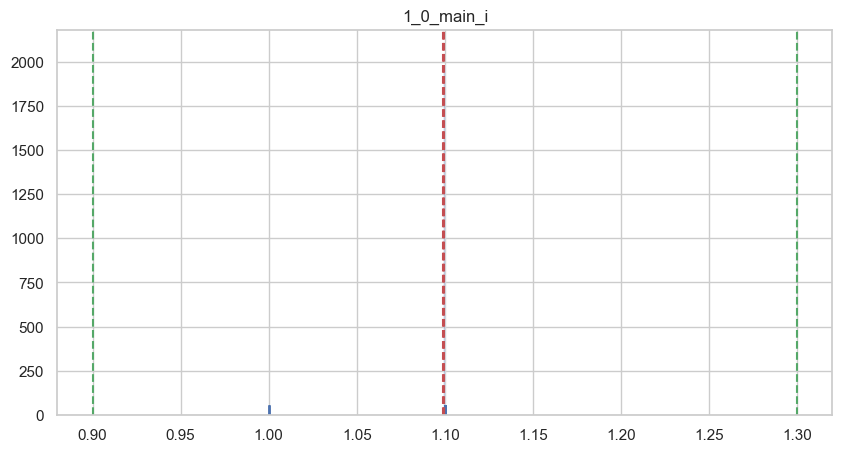

/var/folders/nw/443sknns78l256x46fjj6r0c0000gn/T/ipykernel_94897/3658111960.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(exe_list[key], bins=100, kde=False, rug=True)


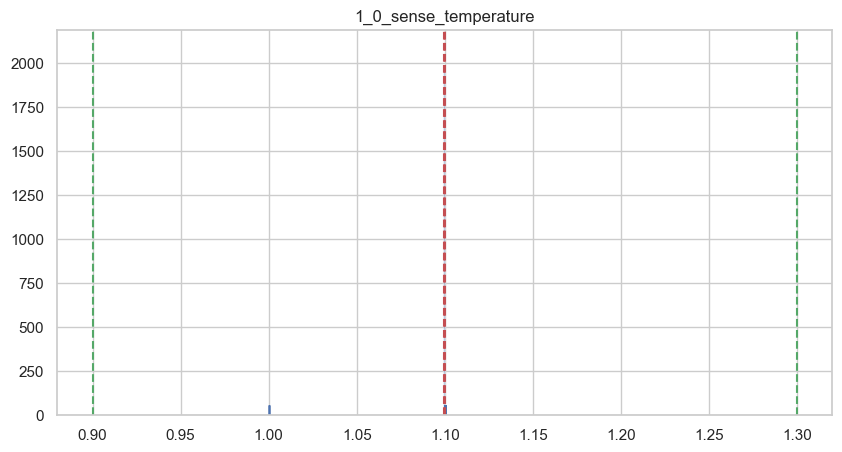

/var/folders/nw/443sknns78l256x46fjj6r0c0000gn/T/ipykernel_94897/3658111960.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(exe_list[key], bins=100, kde=False, rug=True)


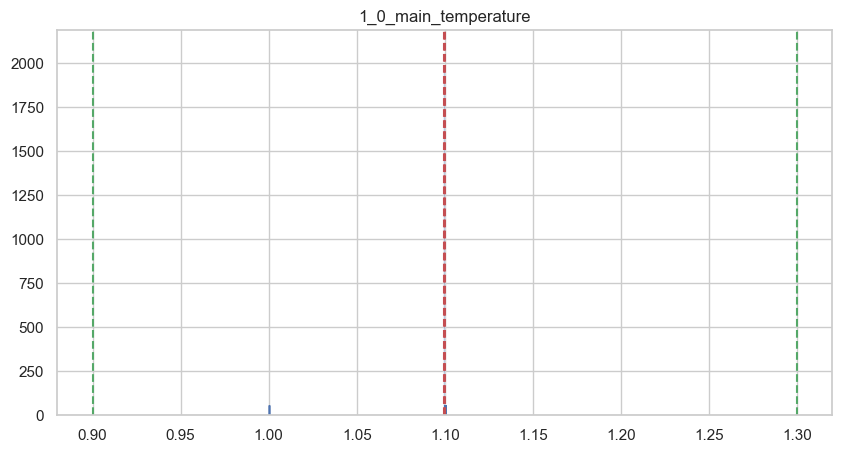

/var/folders/nw/443sknns78l256x46fjj6r0c0000gn/T/ipykernel_94897/3658111960.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(exe_list[key], bins=100, kde=False, rug=True)


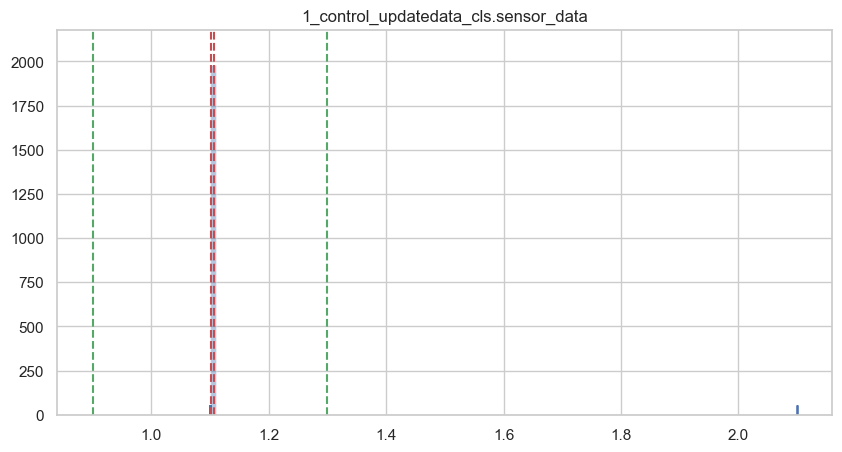

/var/folders/nw/443sknns78l256x46fjj6r0c0000gn/T/ipykernel_94897/3658111960.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(exe_list[key], bins=100, kde=False, rug=True)


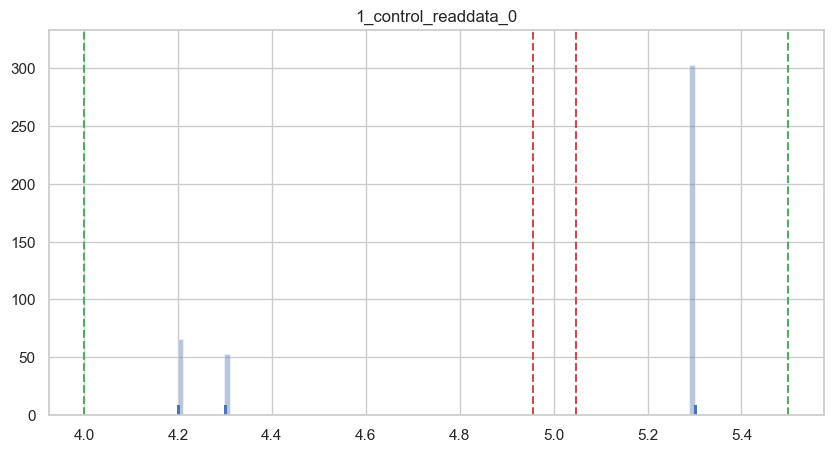

/var/folders/nw/443sknns78l256x46fjj6r0c0000gn/T/ipykernel_94897/3658111960.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(exe_list[key], bins=100, kde=False, rug=True)


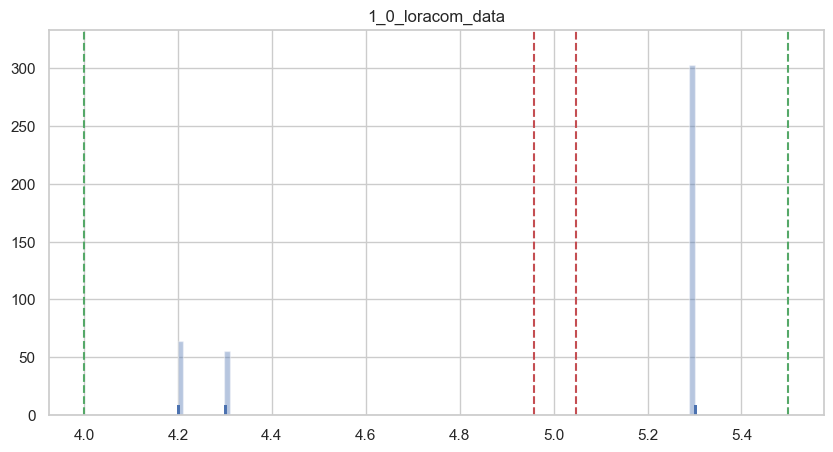

/var/folders/nw/443sknns78l256x46fjj6r0c0000gn/T/ipykernel_94897/3658111960.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(exe_list[key], bins=100, kde=False, rug=True)


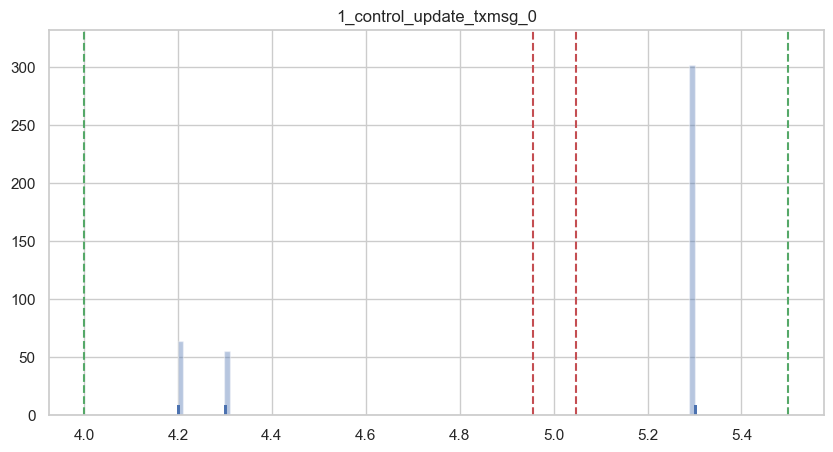

/var/folders/nw/443sknns78l256x46fjj6r0c0000gn/T/ipykernel_94897/3658111960.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(exe_list[key], bins=100, kde=False, rug=True)


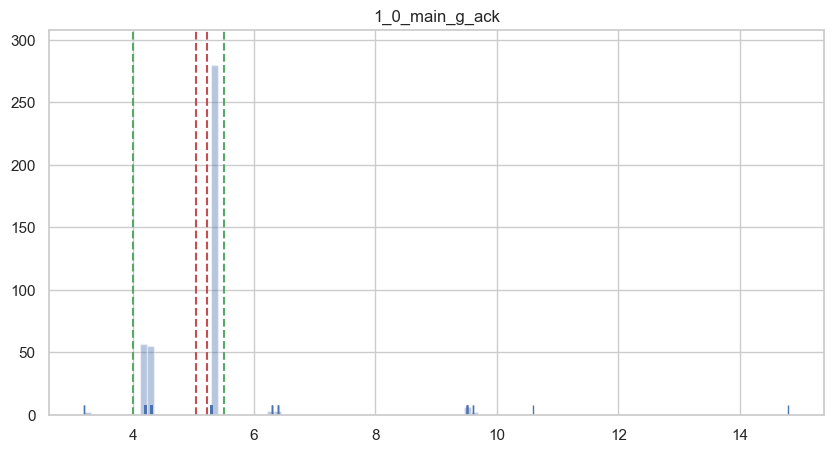

/var/folders/nw/443sknns78l256x46fjj6r0c0000gn/T/ipykernel_94897/3658111960.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(exe_list[key], bins=100, kde=False, rug=True)


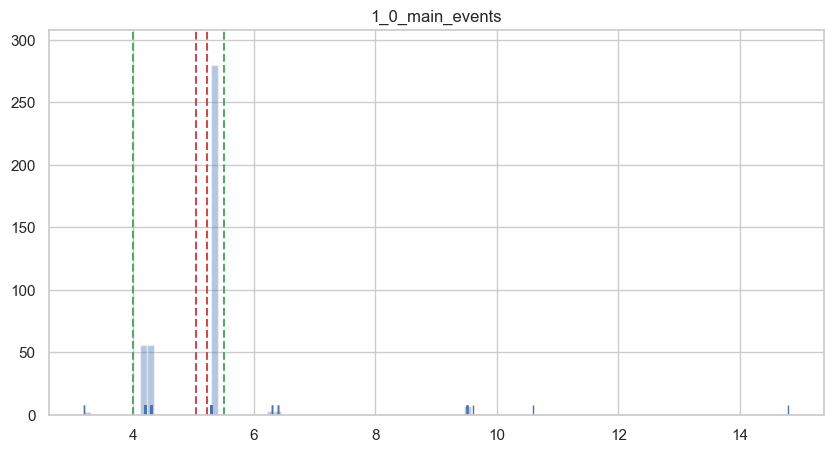

/var/folders/nw/443sknns78l256x46fjj6r0c0000gn/T/ipykernel_94897/3658111960.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(exe_list[key], bins=100, kde=False, rug=True)


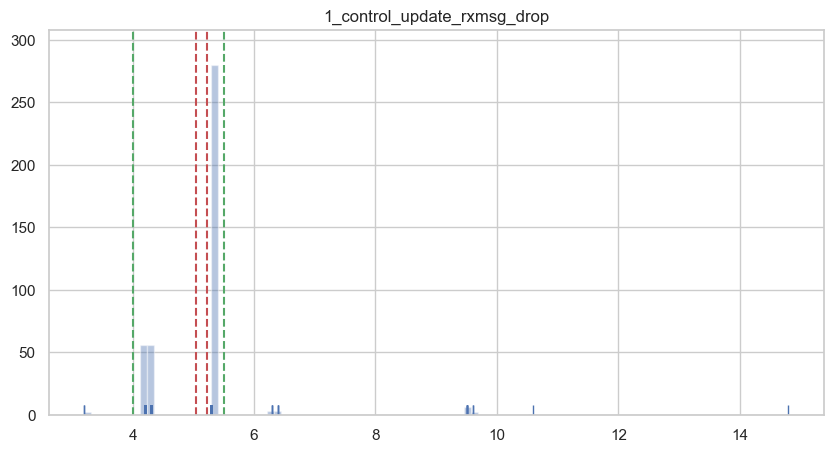

In [60]:
#### plot exe_list to vsiualize the distribution of execution intervals

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

for key in exe_list.keys():
    plt.figure(figsize=(10, 5))
    plt.title(key)
    sns.distplot(exe_list[key], bins=100, kde=False, rug=True)
    plt.axvline(confidence_intervals[key][0], color='r', linestyle='--')
    plt.axvline(confidence_intervals[key][1], color='r', linestyle='--')
    plt.axvline(min(thresholds[key]), color='g', linestyle='--')
    plt.axvline(max(thresholds[key]), color='g', linestyle='--')
    plt.show()

    

### Validation

In [72]:
#### Detect anomalies in faulty traces
detected_anomalies = []
for sample_path in anomalies_tracespaths:
    sample_data = read_traces(sample_path)
    filename = sample_path.split('/')[-1]

    ### iterate trace and make decision for each exe interval
    var_tracking = {}
    for i in range(len(sample_data)):
        event = sample_data[i]
        var, ts = event
        ts = int(ts)
        if var not in var_tracking.keys():
            var_tracking[var] = [ts]
        else:
            var_tracking[var].append(ts)

        ### calculate exe interval
        if len(var_tracking[var]) > 1:
            exe_time = var_tracking[var][-1] - var_tracking[var][-2]
            ### convert timestampt from miliseconds to seconds, and only consdider 1 decimal point. 
            exe_time = round(exe_time/1000, 1)

            ### check if exe_time is an outlier
            if exe_time < thresholds[var][0] or exe_time > thresholds[var][1]:
                print(f'Anomaly detected for {var} in {filename} at {i}th event')
                print(f'Execution interval: {exe_time}')
                detected_anomalies += [[(var, var_tracking[var][-2]), (var, var_tracking[var][-1]), os.path.basename(sample_path)]]

                # break


    break

Anomaly detected for 1_0_main_g_ack in trace1-comm at 1585th event
Execution interval: 6.3
Anomaly detected for 1_0_main_events in trace1-comm at 1586th event
Execution interval: 6.3
Anomaly detected for 1_control_update_rxmsg_drop in trace1-comm at 1587th event
Execution interval: 6.3
Anomaly detected for 1_0_main_g_ack in trace1-comm at 1603th event
Execution interval: 3.2
Anomaly detected for 1_0_main_events in trace1-comm at 1604th event
Execution interval: 3.2
Anomaly detected for 1_control_update_rxmsg_drop in trace1-comm at 1605th event
Execution interval: 3.2
Anomaly detected for 1_0_main_g_ack in trace1-comm at 1780th event
Execution interval: 6.2
Anomaly detected for 1_0_main_events in trace1-comm at 1781th event
Execution interval: 6.2
Anomaly detected for 1_control_update_rxmsg_drop in trace1-comm at 1782th event
Execution interval: 6.2
Anomaly detected for 1_0_main_i in trace1-comm at 1783th event
Execution interval: 1.9
Anomaly detected for 1_0_sense_temperature in trace1

### Visualize Anomalies

In [75]:
########## Visualize the anomalies ############
###############################################

### prepare the traces for plotting

### get variable list that is same for all log files ####
raw_trace = read_traces(normal_tracespaths[0])
_var_list = get_uniquevar(raw_trace)
#np.save('var_list.npy', _var_list, allow_pickle=False)
to_number, from_number = generate_map(_var_list)


########## process the traces ###########
col_data = []
for p in anomalies_tracespaths:
    trace = read_traces(p)
    w = os.path.basename(p).removesuffix('.txt')
    num_trace = []
    time_stamp = []
    for (t, ts) in trace:
        nt = to_number[t]
        num_trace.extend([nt])
        time_stamp.extend([ts])
        # ### take limited samples
        # if ts > 250000:
        #     break
    col_data += [(w, time_stamp, num_trace, _var_list, p)]   ### in the format (trace_name, x_data, y_data, y_labels, trace_path) 


all_df = []
for col in col_data:
    # print(col)
    plot_data = dict()
    plot_data['time'] = col[1]   ### x_data
    plot_data[col[0]] = col[2]   ### y_data (traces)

    ### convert the list to data frame and store it for plotting
    df = pd.DataFrame(plot_data)
    all_df += [df]

In [76]:

####### prepare anomalies for plotting ########

### seperate the anomalies accoring to the trace files and store the timestamps in seperate lists
anomalies = defaultdict(list)
for anomaly in detected_anomalies:
    # print(anomaly)
    file_name = anomaly[2]
    anomalies[file_name] += [anomaly[0][1], anomaly[1][1]]

### sort the anomalies according to the timestamp and remove duplicates
for k in anomalies.keys():
    anomalies[k] = sorted(list(set(anomalies[k])))

### get the index number for timestamps in the traces to plot
anomalies_df = []
for i in range(len(all_df)):
    df = all_df[i]
    k = df.columns[1]   ### get name of the trace
    #print(k)
    anomalies_plot = defaultdict(list)
    for ts in anomalies[k]:
        #print(ts)
        index = df.index[df['time'] == ts].tolist()
        ### store the respective values from the trace columns
        y_val = df[k].iloc[index[0]]
        #print(index, y_val)
        anomalies_plot['index'] += index
        anomalies_plot[k+'-anomalies'] += [y_val]

    ### convert the dict to data frame and store it for plotting
    df = pd.DataFrame(anomalies_plot)
    anomalies_df += [df]
    

In [77]:
##### plot the traces with anomalies #####

import plotly.graph_objects as go
import pandas as pd




### add all the traces to the graph
for df in all_df:

    ### plot only one graph
    trace_toplot = 0
    df = all_df[trace_toplot]
    dfa = anomalies_df[trace_toplot]
    ############################

    # Create figure
    fig = go.Figure()

    df_col = df.columns
    fig.add_trace(
                go.Scatter(y=list(df[df_col[1]]), name=df_col[1]),   ### equivalent to: y=list(df['trace1'])
                )
    ### add anomalies to the graph without lines
    for (ax, ay) in zip(dfa['index'], dfa[df_col[1]+'-anomalies']):
        fig.add_trace(
                go.Scatter(x=[ax], y=[ay], name=df_col[1]+'-anomalies', mode='markers', marker=dict(size=10, color='red'), showlegend=False),
                )
    
    
    # break
    ### generate x ticks with timestamp and index num  
    x_data = df[df_col[0]]
    x_ticks = [(i,x_data[i]) for i in range(0,len(x_data),10) ]

    # Add range slider, title, yticks, axes labels
    fig.update_layout(
        title_text="Event Trace without Time",
        xaxis=dict(
            title="Number of events",
            rangeslider=dict(visible=True),
            type='linear',
            tickvals=[k for k in range(0,len(x_data),10)],
            ticktext=x_ticks
        ),
        yaxis=dict(
            title="Variables",
            tickvals=[k for k in range(1,len(_var_list)+1)],
            ticktext=_var_list
        ),
        autosize=True,
        width=1200,
        height=600,
        
    )


    # style all the traces
    fig.update_traces(
        #hoverinfo="name+x+text",
        line={"width": 0.5},
        marker={"size": 8},
        mode="lines+markers",
        showlegend=True,
        
    )

    fig.show()
    break

### Evaluation

In [7]:
############ Evaluation ############
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

Accuracy: 0.7490
F1 Score: 0.7448
Confusion Matrix:
[[93  4]
 [57 89]]
Precision: 0.9570
Recall: 0.6096


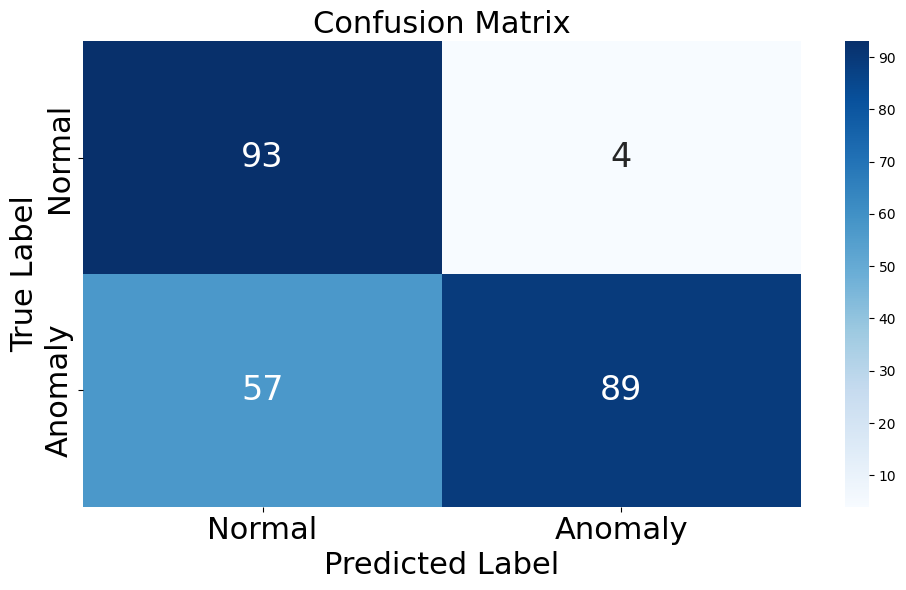

In [8]:
############ plot the confusion matrix ############
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create the labels for the Confusion Matrix
labels = ['Normal', 'Anomaly']

# Make predictions on the test data
y_pred = np.array(y_pred)
y_true = np.array(y_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a DataFrame for the Confusion Matrix
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

# Create the Confusion Matrix
plt.figure(figsize=(10, 6))
#sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g', annot_kws={"size": 24})  # Change font size

# increase label font size
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)

# increase title font size


plt.title('Confusion Matrix', fontsize=22)
plt.ylabel('True Label', fontsize=22)
plt.xlabel('Predicted Label', fontsize=22)
plt.tight_layout()
# plt.savefig('confusion_matrix.png', dpi=300)
plt.show()